<a href="https://colab.research.google.com/github/Ghassen-Cherni/CenterNet/blob/main/KuzushijiKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Kuzushi Recognition Kaggle Challenge




In [1]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage.feature import peak_local_max
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torchvision
import numpy as np
import json
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import random
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import glob
import gc
import os  
from torchvision import transforms
import pickle
import torch.optim as optim


# Pre-processing



In [2]:
cd drive/MyDrive/Kuzushiji\ Recognition/

/content/drive/MyDrive/Kuzushiji Recognition


In [3]:
sample_submission=pd.read_csv("sample_submission.csv")
sample_submission.head()

image_id                 labels   Useage
0  test_001c37e2  U+003F 1 1 U+FF2F 2 2  Private
1  test_003aa33a  U+003F 1 1 U+FF2F 2 2   Public
2  test_00665e33  U+003F 1 1 U+FF2F 2 2  Private
3  test_0082d2cd  U+003F 1 1 U+FF2F 2 2  Private
4  test_0086f578  U+003F 1 1 U+FF2F 2 2  Private

In [4]:
train=pd.read_csv("train.csv")
train.head()

image_id                                             labels
0  100241706_00004_2  U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1  100241706_00005_1  U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2  100241706_00005_2  U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3  100241706_00006_1  U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4  100241706_00007_2  U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...

In [ ]:
unicode_translation=pd.read_csv("unicode_translation.csv")
unicode_map = {Unicode: char for Unicode, char in unicode_translation.values}

In [ ]:
#### Ici on rempli un dictionnaire avec les labels pour chaque image

dictionnary_labels_per_image = {}
for image_id in train['image_id'].values:
    size = cv2.imread('train_images/{}.jpg'.format(image_id)).shape
    labels = train[train['image_id']==image_id].labels.values[0].split(' ')
    letters = []
    bbox = []
  
    for i,l in enumerate(labels[::5]):
        letters.append(l)
        bbox.append([int(x) for x in labels[i*5+1:i*5+5]])

    dictionnary_labels_per_image[image_id]={"letters":letters,"bbox":bbox,"size":size}

In [5]:

# with open('dictionnary_labels_per_image.pickle', 'wb') as handle:
#     pickle.dump(dictionnary_labels_per_image, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dictionnary_labels_per_image.pickle', 'rb') as handle:
    dictionnary_labels_per_image = pickle.load(handle)

# Visualization of the data

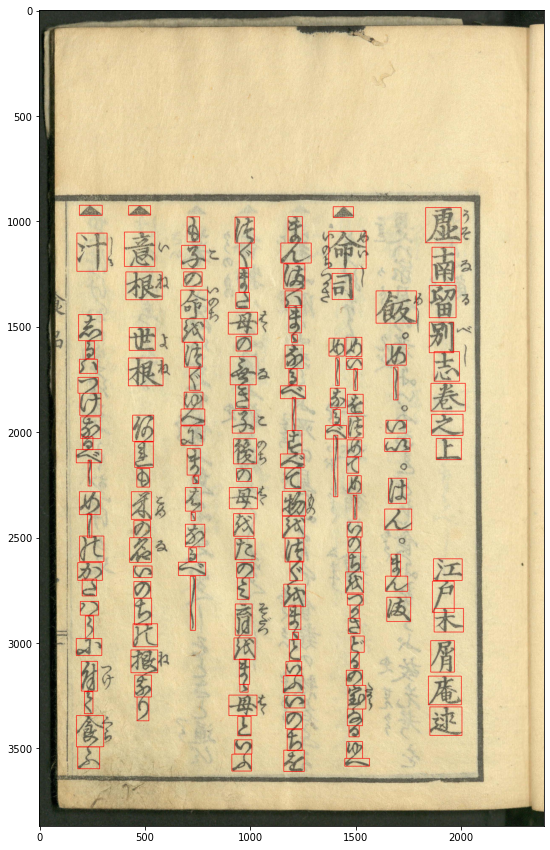

In [ ]:
def image_visualization(image_id, viz=False):    
    if viz==True:
        img = cv2.imread('train_images/{}.jpg'.format(image_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for elements in dictionnary_labels_per_image[image_id]["bbox"]:
            cv2.rectangle(img, (elements[0], elements[1]), (elements[0]+elements[2], elements[1]+elements[3]), (255, 0, 0), 2)
        plt.figure(figsize=(15, 15))
        imgplot = plt.imshow(img)
    

image_visualization("100241706_00007_2", viz=True)

# Target generation (Heatmaps on which the model learns)

In [6]:
### How can I optimize it
def gaussian_heatmap(sigma, center_x, center_y, size_x, size_y, heatmap):
#     for i in range(heatmap.shape[0]):
#         for j in range(heatmap.shape[1]):
#             gaussian = np.exp(-((j-center_x)*(j-center_x)+(i-center_y)*(i-center_y))/(2*sigma*sigma))
#             if gaussian > heatmap[i, j]:
#                 heatmap[i,j]=gaussian
    sigma_x = size_x/10
    sigma_y = size_y/10              
    point = np.exp(-(np.arange(128)-center_x)**2/(2*sigma_x*sigma_x)).reshape(1,-1
                                                                         )*np.exp(-(np.arange(128)-center_y)**2/(2*sigma_y*sigma_y)).reshape(-1,1)
    heatmap=np.maximum(heatmap,point)
    return heatmap


In [7]:
def generate_heatmap_offset(image_id, sigma):
    heatmap = np.zeros((128, 128))
    offset_x = np.zeros((128, 128))
    offset_y = np.zeros((128, 128))
    object_size_x =  np.zeros((128, 128))
    object_size_y =  np.zeros((128, 128))
    bbox = dictionnary_labels_per_image[image_id]["bbox"]
    img_shape = dictionnary_labels_per_image[image_id]["size"]
    
    for i in range(len(bbox)):
        center_x = bbox[i][0]+bbox[i][2]//2
        center_y = bbox[i][1]+bbox[i][3]//2

        center_x_resized_float = center_x/img_shape[1] * 128
        center_y_resized_float = center_y/img_shape[0] * 128
        
        center_x_resized_int = int(center_x_resized_float)
        center_y_resized_int = int(center_y_resized_float)
        
        heatmap = gaussian_heatmap(sigma, center_x_resized_int, 
                                   center_y_resized_int,bbox[i][2]/img_shape[1] * 128, 
                                   bbox[i][3]/img_shape[0] * 128, heatmap)
        offset_x[center_y_resized_int, center_x_resized_int] = center_x_resized_float - center_x_resized_int
        offset_y[center_y_resized_int, center_x_resized_int] = center_y_resized_float - center_y_resized_int
        object_size_x[center_y_resized_int, center_x_resized_int] = ((bbox[i][2]/img_shape[1] * 128)/2)
        object_size_y[center_y_resized_int, center_x_resized_int] = ((bbox[i][3]/img_shape[0] * 128)/2)
        
    return heatmap, offset_x, offset_y, object_size_x, object_size_y

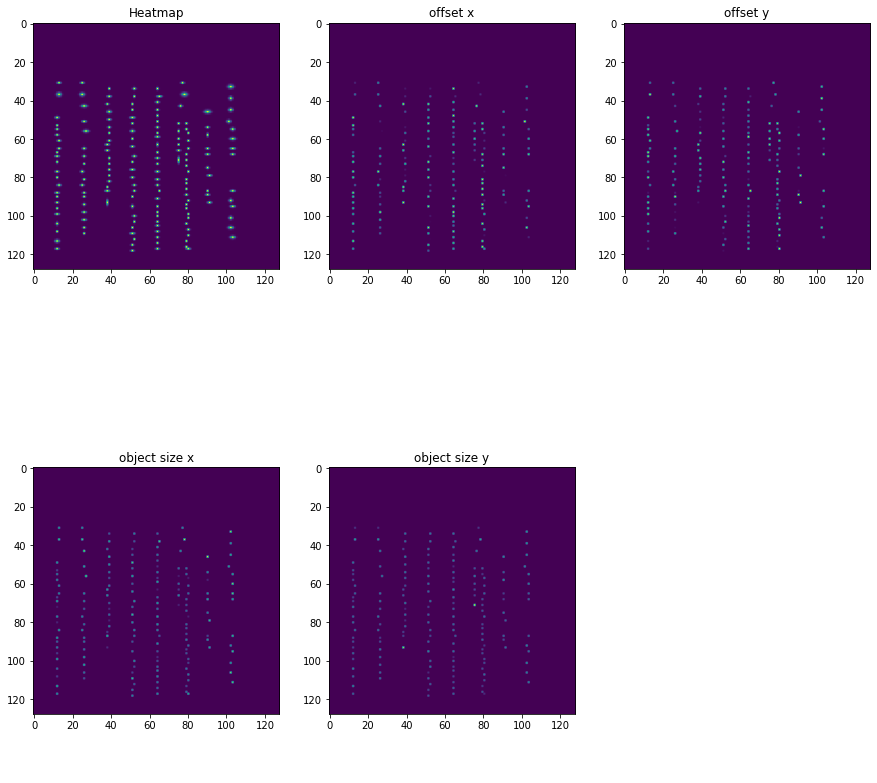

In [ ]:
heatmap, offset_x, offset_y, object_size_x, object_size_y = generate_heatmap_offset("100241706_00007_2",1)

fig, axes = plt.subplots(2, 3,figsize=(15,15))
axes[0,0].set_title('Heatmap')
axes[0,0].imshow(heatmap)
axes[0,1].set_title('offset x')
axes[0,1].imshow(offset_x)
axes[0,2].set_title('offset y')
axes[0,2].imshow(offset_y)
axes[1,0].set_title('object size x')
axes[1,0].imshow(object_size_x)
axes[1,1].set_title('object size y')
axes[1,1].imshow(object_size_y)
axes[1,2].set_axis_off()
plt.show()

In [ ]:
gc.collect()

114

In [8]:
def heatmap_to_image(heatmap, offset_x, offset_y, object_size_x, object_size_y,image_id):
    coordinates = peak_local_max(heatmap, min_distance=9)
    img = cv2.imread('train_images/{}.jpg'.format(image_id)) 
    ratio_x = img.shape[0]/heatmap.shape[0]
    ratio_y = img.shape[1]/heatmap.shape[1]

    for i,coords in enumerate(coordinates):
        bbox_x1=int((coordinates[i][0]*ratio_x+offset_y[coords[0],coords[1]]*ratio_x) - object_size_y[coords[0],coords[1]]*ratio_x)
        bbox_y1=int((coordinates[i][1]*ratio_y+offset_x[coords[0],coords[1]]*ratio_y)- object_size_x[coords[0],coords[1]]*ratio_y)
        width_x = int(bbox_x1+object_size_y[coords[0],coords[1]]*ratio_x*2)
        width_y = int(bbox_y1+object_size_x[coords[0],coords[1]]*ratio_y*2)
        cv2.rectangle(img, (bbox_y1, bbox_x1), (width_y, width_x), (255, 0, 0), 2)
    #coordinates_adjusted = np.stack((coordinates[:,0]*ratio_x,coordinates[:,1]*ratio_y),axi=1).astype(int)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(img)

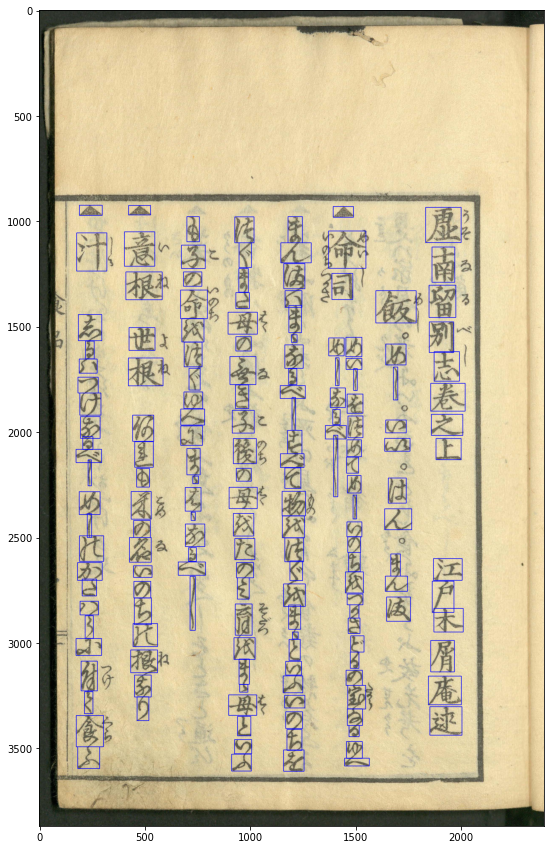

In [ ]:
heatmap_to_image(heatmap, offset_x, offset_y, object_size_x, object_size_y,"100241706_00007_2")

# Model and losses definition

In [9]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet18"):
        super(centernet, self).__init__()
        # create backbone.
        basemodel = torchvision.models.resnet18(pretrained=True) # turn this on for training
        basemodel = nn.Sequential(*list(basemodel.children())[:-2])
        # set basemodel
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue box size
        self.outr = nn.Conv2d(256, 2, 1) 
        # output residue offset
        self.outo = nn.Conv2d(256, 2, 1) 
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        outo = self.outo(x)
        return outc, outr, outo

In [10]:
### Let's define our losses 

def neg_loss(pred, gt):
    ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
    '''
    pred = pred.unsqueeze(1).float()
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()
    neg_weights = torch.pow(1 - gt, 4)

    loss = 0

    pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
      loss = loss - neg_loss
    else:
      loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

# def _reg_loss(regr, gt_regr, mask):
#     ''' L1 regression loss
#     Arguments:
#       regr (batch x max_objects x dim)
#       gt_regr (batch x max_objects x dim)
#       mask (batch x max_objects)
#     '''
#     num = mask.float().sum()
#     #print(gt_regr.size())
#     mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
#     #print(mask.size())

#     regr = regr * mask
#     gt_regr = gt_regr * mask

#     regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
#     regr_loss = regr_loss / (num + 1e-4)
#     return regr_loss

def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  # print('regr shape',regr.size())
  # print('ground truth regr shape',gt_regr.size())
  # print('mask shape', mask.size())
  # print('mask unsqueezed shape', mask.unsqueeze(1).size())
  num = mask.float().sum()
  mask = mask.unsqueeze(1).expand_as(gt_regr) #.float()

  regr = regr * mask
  gt_regr = gt_regr * mask
    
  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
def centerloss(prediction, mask, regr, offset, weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    mask_loss = neg_loss(pred_mask, mask)
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:3]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1) ## to check reg loss
    regr_loss = regr_loss.mean(0)
    #regr_loss = _reg_loss(pred_regr, regr, mask)

    pred_offset = prediction[:, 3:5]
    offset_loss = (torch.abs(pred_offset - offset).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1) ## to check reg loss
    offset_loss = offset_loss.mean(0)
  
    # Sum
    loss = mask_loss +regr_loss+offset_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss, offset_loss

# Dataloader creation

In [11]:
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = (image.astype(np.float32)/255)
        image -= self.mean
        image /= self.std
        return image


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_id):
        self.img_id = img_id
        self.normalize = Normalize()
        

    def __getitem__(self, index):
      
        img = cv2.resize(cv2.imread('train_images/{}.jpg'.format(self.img_id[index])),(512,512))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        heatmap, offset_x, offset_y, object_size_x, object_size_y = generate_heatmap_offset(self.img_id[index], 1)
        regr = np.zeros((2, 128, 128))
        offset = np.zeros((2, 128, 128))
        regr[0,:,:]=object_size_x
        regr[1,:,:]=object_size_y

        offset[0,:,:]=offset_x
        offset[1,:,:]=offset_y
        return img,self.img_id[index], heatmap, regr, offset
    
    def __len__(self):
        return len(self.img_id)

class DatasetTest(torch.utils.data.Dataset):
    def __init__(self, img_id):
        self.img_id = img_id
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, index):

        img = cv2.resize(cv2.imread('test_images/{}'.format(self.img_id[index])),(512,512))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        return img, self.img_id[index]

traindataset = MyDataset(train.image_id.values)

### Change number of workers to 4 and set pin_memory = True
### If you want a variable to not use graph tree use .detach() insted of .numpy() or .float()
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=20,shuffle=True, num_workers=6,
                                           pin_memory = True)

testdataset = DatasetTest(os.listdir("test_images"))
test_loader = torch.utils.data.DataLoader(testdataset,batch_size=20,shuffle=False, num_workers=6,
                                          pin_memory = True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Leslie N. Smith test for max and min learning rate finding

In [12]:
def lesli_lr_range(lr_min, lr_max, epochs = 1):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = centernet()
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=1e-8)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=((1e-2)-(1e-5))/30)
  logs = []
  model.train()
  running_loss = 0.0
  running_mask = 0.0
  running_regr = 0.0
  running_offset = 0.0

  for epoch in range(epochs):
    t = tqdm(train_loader)
    for idx, (img,index, hm, regr, offset) in enumerate(t):       
      # send to gpu
      img = img.to(device)
      hm_gt = hm.to(device)
      regr_gt = regr.to(device)
      offset_gt = offset.to(device)
      # set opt
      ## set_to_none=True apparently optimizes the memory usage
      optimizer.zero_grad(set_to_none=True)
      
      # run model
      hm, regr, offset = model(img)
      preds = torch.cat((hm, regr,offset), 1)
          
      loss, mask_loss, regr_loss, offset_loss = centerloss(preds, hm_gt, regr_gt, offset_gt)
      # misc
      running_loss = loss
      running_mask = mask_loss
      running_regr = regr_loss
      running_offset = offset_loss

      loss.backward()
      optimizer.step()
      
      t.set_description(f't (l={running_loss/(idx+1):.3f})(m={running_mask/(idx+1):.4f})(r={running_regr/(idx+1):.4f})(o={running_offset/(idx+1):.4f})')
      #scheduler.step()
      for g in optimizer.param_groups:
        g['lr'] = g['lr']+((lr_max)-(lr_min))/(181*epochs)
      log_mini_batch = {'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                      'loss': running_loss, "mask": running_mask, 
                  "regr": running_regr, 'offset': running_offset}
      

      logs.append(log_mini_batch)
      #print("Learning rate ", optimizer.state_dict()['param_groups'][0]['lr'])
      gc.collect()
  return logs

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logs = lesli_lr_range(lr_min=1e-8, lr_max=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
lr = []
loss = []
loss_reg = []
loss_mask = []
loss_offset = []
for l in logs:
  lr.append(l['lr'])
  loss.append(l['loss'])
  loss_reg.append(l['regr'])
  loss_mask.append(l['mask'])
  loss_offset.append(l['offset'])

beta = 0.8
avg_loss = 0
avg_loss_regr = 0
avg_loss_mask = 0
avg_loss_offset = 0
smoothed_losses=[]
smoothed_losses_regr=[]
smoothed_losses_mask=[]
smoothed_losses_offset=[]

for i,l in enumerate(loss):
  avg_loss = beta * avg_loss + (1-beta) *l
  smoothed_loss = avg_loss / (1 - beta**i)
  smoothed_losses.append(smoothed_loss)

for i,l in enumerate(loss_reg):
  avg_loss_regr = beta * avg_loss_regr + (1-beta) *l
  smoothed_loss_regr = avg_loss_regr / (1 - beta**i)
  smoothed_losses_regr.append(smoothed_loss_regr)

for i,l in enumerate(loss_mask):
  avg_loss_mask = beta * avg_loss_mask + (1-beta) *l
  smoothed_loss_mask = avg_loss_mask / (1 - beta**i)
  smoothed_losses_mask.append(smoothed_loss_mask)

for i,l in enumerate(loss_offset):
  avg_loss_offset = beta * avg_loss_offset + (1-beta) *l
  smoothed_loss_offset = avg_loss_offset / (1 - beta**i)
  smoothed_losses_offset.append(smoothed_loss_offset)


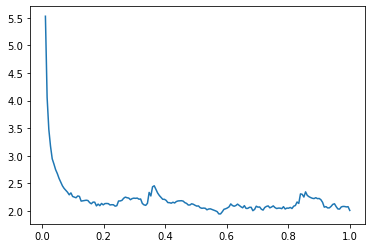

In [ ]:
plt.plot(lr,smoothed_losses_regr)

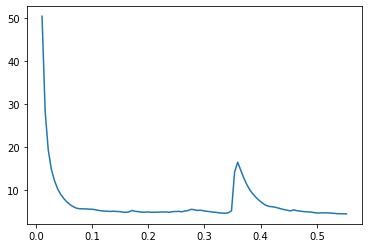

In [ ]:
plt.plot(lr[:100],smoothed_losses[:100])

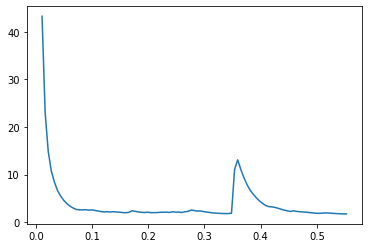

In [ ]:
plt.plot(lr[:100],smoothed_losses_mask[:100])

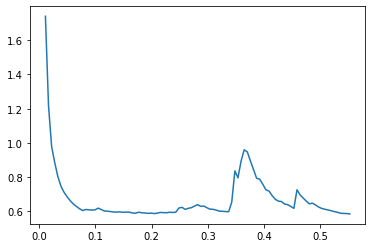

In [ ]:
plt.plot(lr[:100],smoothed_losses_offset[:100])

# Training loop definition

In [13]:
import math
def plot_from_log(logs, plot=['total_loss'], plot_type='training'):
  absciss = []
  total_loss = []
  lr = []
  mask_loss = []
  regr_loss = []
  temp = len(plot)
  #fig = plt.figure(figsize=(8,6))
  if len(plot)>2:
    fig, axs = plt.subplots(len(plot)-math.floor(len(plot)/2), 2,figsize=(15,15))
  elif len(plot)==2:
    fig, axs = plt.subplots(len(plot)-math.floor(len(plot)/2), 2,figsize=(15,15))
    axs=[axs]
  else:
    fig, axs = plt.subplots(figsize=(5,5))
    axs = [[axs]]

  for log in logs:
    if plot_type=='training':
      absciss.append(log['epoch'])
      lr.append(log['lr'])
    elif plot_type=='lesli_experience':
      absciss.append(log['lr'])
    total_loss.append(log['loss'])
    mask_loss.append(log['mask'])
    regr_loss.append([log['regr']])
  
  column = 0 

  for i,ax in enumerate(axs):
    if 'total_loss' in plot:
      ax[column].plot(absciss, total_loss)
      ax[column].title.set_text('total loss curve')
      column+=1
      plot.remove('total_loss')
      if column==2:
        column=0
        continue 
      
    if 'lr' in plot and plot_type=='training':
      ax[column].plot(absciss, lr)
      ax[column].title.set_text('learning rate curve')
      column+=1
      plot.remove('lr')
      if column==2:
        column=0
        continue 
    if 'mask_loss' in plot:
      ax[column].plot(absciss, mask_loss)
      ax[column].title.set_text('mask loss curve')
      column+=1
      plot.remove('mask_loss')
      if column==2:
        column=0
        continue
    if 'regr_loss' in plot:
      ax[column].plot(absciss, regr_loss)
      ax[column].title.set_text('regression loss curve')
      column+=1
      plot.remove('regr_loss')
      if column==2:
        column=0
        continue

  if temp%2 != 0 and temp>2:

    axs[-1,1].remove()


In [14]:
def train_model(epoch, optimizer, scheduler=None, epochs=10, logs=[]):
  model.train()
  print('epochs {}/{} '.format(epoch+1,epochs))
  #print('learning rate {} '.format(optimizer.state_dict()['param_groups'][0]['lr']))
  running_loss = 0.0
  running_mask = 0.0
  running_regr = 0.0
  running_offset = 0.0
  t = tqdm(train_loader)
  rd = np.random.rand()

  for idx, (img,index, hm, regr, offset) in enumerate(t):       
      # send to gpu
      img = img.to(device)
      hm_gt = hm.to(device)
      regr_gt = regr.to(device)
      offset_gt = offset.to(device)
      # set opt
      ## set_to_none=True apparently optimizes the memory usage
      optimizer.zero_grad(set_to_none=True)
      
      # run model
      hm, regr, offset = model(img)
      preds = torch.cat((hm, regr, offset), 1)
          
      loss, mask_loss, regr_loss, offset_loss = centerloss(preds, hm_gt, regr_gt, offset_gt)
      # misc
      running_loss += loss
      running_mask += mask_loss
      running_regr += regr_loss
      running_offset += offset_loss
      loss.backward()
      optimizer.step()
        
      t.set_description(f't (l={running_loss/(idx+1):.3f})(m={running_mask/(idx+1):.4f})(r={running_regr/(idx+1):.4f})(o={running_offset/(idx+1):.4f})')
  

  print('learning rate : ', optimizer.param_groups[0]['lr'])
  print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
  print('maskloss : {:.4f}'.format(running_mask/(len(train_loader))))
  print('regrloss : {:.4f}'.format(running_regr/(len(train_loader))))
  print('offsetloss : {:.4f}'.format(running_offset/(len(train_loader))))
  # save logs
  log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                  'loss': running_loss/len(train_loader), "mask": running_mask/(len(train_loader)), 
                "regr": running_regr/(len(train_loader)), 'offset': running_offset/(len(train_loader))}

  logs.append(log_epoch)
  if scheduler is not None:
      scheduler.step()
  return logs

In [ ]:
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = centernet()
model.to(device)


In [16]:

def train_loop(model, scheduler_name=None, epochs=10):
  if scheduler_name is None:
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = None
  else:
    optimizer = optim.SGD(model.parameters(), lr=1e-2)
    if scheduler_name == 'cosine':
      scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, eta_min=1e-3)
    elif scheduler_name == 'one_cycle':
      scheduler == torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=epochs, steps_per_epoch=181, three_phase=True)
 
  learning_rates = []
  logs = []
  for epoch in range(epochs):
    logs = train_model(epoch, scheduler = scheduler, epochs=epochs, optimizer=optimizer, logs = logs)
    #torch.save(model.state_dict(), "model")
    gc.collect()
  return logs

In [ ]:
### 1 epoch en plus
logs = train_loop(model, scheduler_name=None)

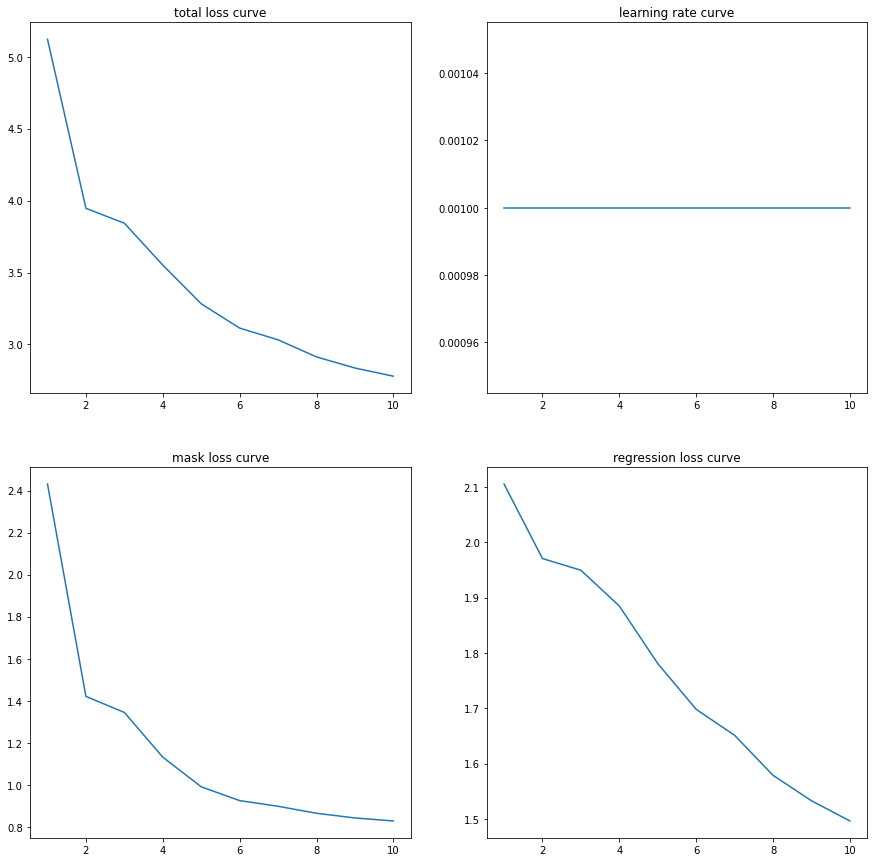

In [ ]:
plot_from_log(logs,plot = ['mask_loss', 'regr_loss','lr', 'total_loss'])

# Results visualization

In [42]:
def heatmap_to_image_test(heatmap, object_size_x, object_size_y,image_id):
    heatmap[heatmap<0.5]=0
    coordinates = peak_local_max(heatmap, min_distance=1)

    img = cv2.imread('test_images/{}'.format(image_id)) 
    ratio_x = img.shape[0]/heatmap.shape[0]
    ratio_y = img.shape[1]/heatmap.shape[1]

    for i,coords in enumerate(coordinates):
        bbox_x1=int((coordinates[i][0])*ratio_x - object_size_y[coords[0],coords[1]])
        bbox_y1=int((coordinates[i][1])*ratio_y- object_size_x[coords[0],coords[1]])
        width_x = int(bbox_x1+object_size_y[coords[0],coords[1]]*2)
        width_y = int(bbox_y1+object_size_x[coords[0],coords[1]]*2)
        cv2.rectangle(img, (bbox_y1, bbox_x1), (width_y, width_x), (255, 0, 0), 2)
        center_x = int(coordinates[i][0]*ratio_x)
        center_y = int(coordinates[i][1]*ratio_y)
        img = cv2.circle(img, (center_y,center_x), radius=10, color=(0, 0, 255), thickness=-1)

    #coordinates_adjusted = np.stack((coordinates[:,0]*ratio_x,coordinates[:,1]*ratio_y),axi=1).astype(int)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(img)

In [40]:
def heatmap_to_image_train(heatmap, object_size_x, object_size_y,image_id):
    heatmap[heatmap<0.5]=0
    coordinates = peak_local_max(heatmap, min_distance=1)

    img = cv2.imread('train_images/{}.jpg'.format(image_id)) 
    ratio_x = img.shape[0]/heatmap.shape[0]
    ratio_y = img.shape[1]/heatmap.shape[1]

    for i,coords in enumerate(coordinates):
        bbox_x1=int((coordinates[i][0])*ratio_x - object_size_y[coords[0],coords[1]])
        bbox_y1=int((coordinates[i][1])*ratio_y- object_size_x[coords[0],coords[1]])
        width_x = int(bbox_x1+object_size_y[coords[0],coords[1]]*2)
        width_y = int(bbox_y1+object_size_x[coords[0],coords[1]]*2)
        cv2.rectangle(img, (bbox_y1, bbox_x1), (width_y, width_x), (255, 0, 0), 2)
        center_x = int(coordinates[i][0]*ratio_x)
        center_y = int(coordinates[i][1]*ratio_y)
        img = cv2.circle(img, (center_y,center_x), radius=10, color=(0, 0, 255), thickness=-1)

    #coordinates_adjusted = np.stack((coordinates[:,0]*ratio_x,coordinates[:,1]*ratio_y),axi=1).astype(int)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(img)

In [26]:
model.load_state_dict(torch.load('model'))

<All keys matched successfully>

In [27]:
l = iter(train_loader)
example = next(l)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [28]:
img_id = example[1][0]
img = example[0][0]
model.eval()
with torch.no_grad():
      hm, regr = model(img.to(device).float().unsqueeze(0))

  
hm = hm.cpu().numpy().squeeze(0).squeeze(0)
regr = regr.cpu().numpy().squeeze(0)

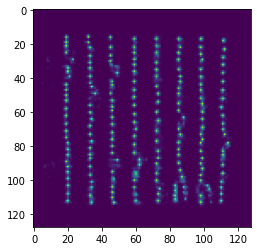

In [39]:
m = torch.sigmoid(torch.from_numpy(hm)).numpy()
plt.imshow(m)
plt.show()

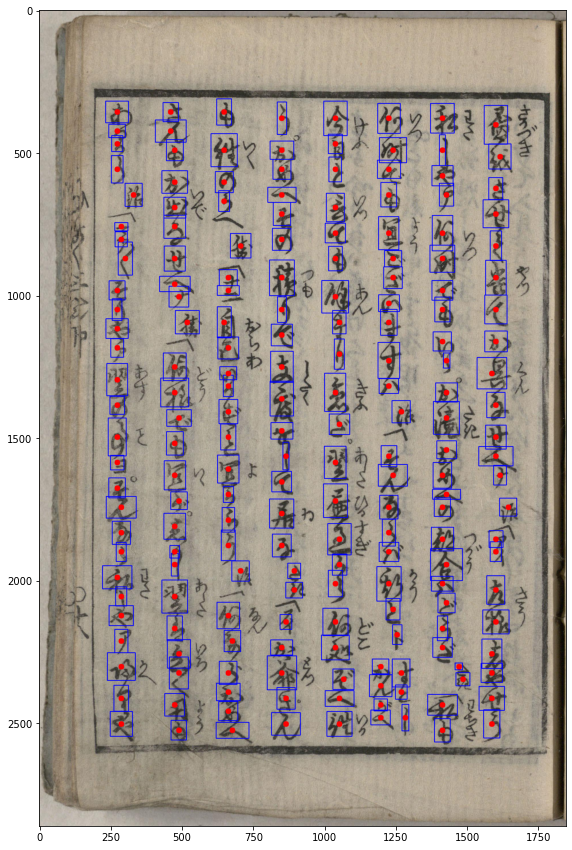

In [41]:
heatmap_to_image_train(m,regr[0],regr[1],img_id)

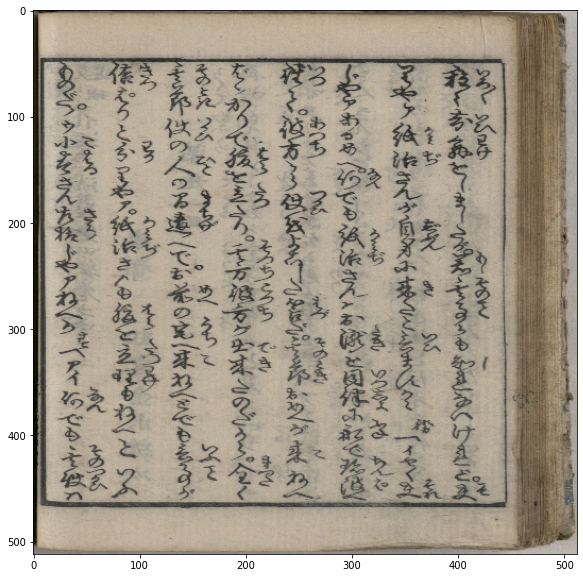

In [ ]:
img = cv2.resize(cv2.imread('train_images/{}.jpg'.format(img_id)),(512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [51]:
#ll = iter(test_loader)
examplel = next(ll)

In [52]:
img_idl = examplel[1][0]
imgl = examplel[0][0]
model.eval()
with torch.no_grad():
      hml, regrl = model(imgl.to(device).float().unsqueeze(0))

  
hml = hml.cpu().numpy().squeeze(0).squeeze(0)
regrl = regrl.cpu().numpy().squeeze(0)

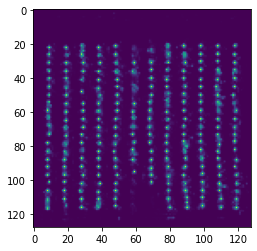

In [53]:
ml = torch.sigmoid(torch.from_numpy(hml)).numpy()
plt.imshow(ml)
plt.show()

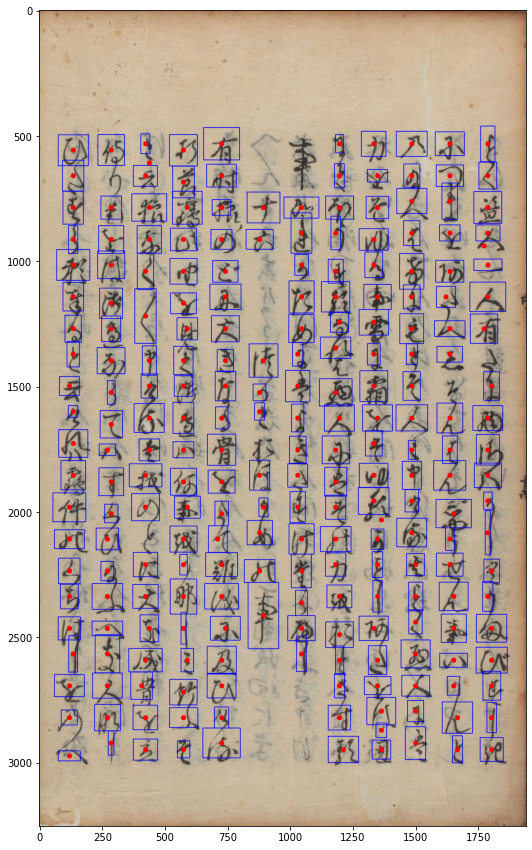

In [54]:
heatmap_to_image_test(ml,regrl[0],regrl[1],img_idl)